<a href="https://colab.research.google.com/github/waltermayor/DigitalImageProcessing_colab/blob/master/Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis (PCA)

PCA es fundamentalmente un algoritmo de redución de dimensionalidad. Pero puede ser tambien usado como una herramienta de visualización para filtrar ruido, extraer caracteristicas y mucho mas.



In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introducción a PCA

PCA es un metodo no supervisionando rapido y flexible para la redución de dimencionalidad de los datos. Lo cual puede ser facilmente observado en un ejemplo en 2 dimesiones 


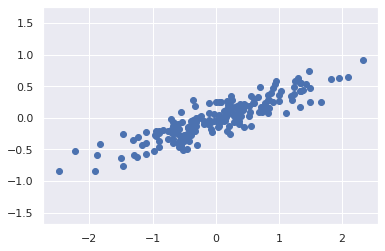

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

Claramente se ve una relación lineal entre los datos. Uno de los objetivos de PCA en tratar de encontrar la relación entre los valores (x) y (y). Este relación es cuantificada encontrando una lista de componentes principales en los datos y usando estos componentes para describir los datos.

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

La función fit entrega datos importantes que ella llama componenetes y varianza explicada. 



In [5]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [6]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


Los "componentes" y "la varinza explicada" es lo que nosotos conocemos desde el algebra lineal como Autovectores y Autovalores. Los Autovectores definen la dirección del vector y los Autovalores definen la longitud al cuadrado del vector.


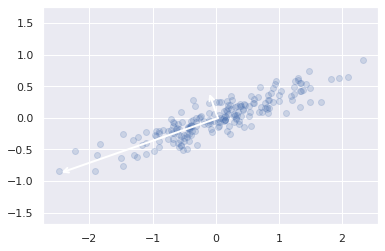

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Los vectores representan los ejes principales "componentes" o "autovectores" y la longitud del vector nos indica que tan "importante" ese eje es para realizar una descripción del los datos. Es tambien una medición de la varianza para los datos proyectados en cada uno de los ejes (autovalores)  

El resultado de los datos proyectados sobre los ejes principales es conocido como los componentes principales de los datos.


![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.09-PCA-rotation.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Principal-Components-Rotation)

La transformación de los ejes de los datos a los ejes principales es una tranfomormación afin, la cual basicamente esta compuesta de una translación, rotación y escalado uniforme.



Juguemos con los autovalores y autovectores

[8.95785778 4.44486039]
[-2.2224302   4.47892889]
[0.89578578 0.44448604]
[-0.44448604  0.89578578]


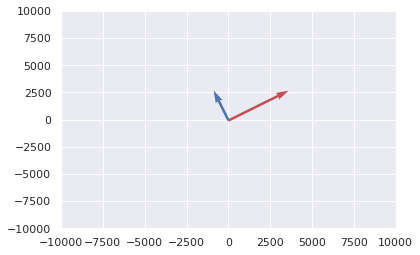

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from numpy import linalg as LA


# matriz de covarianza para 2 features y N muestras (2 x N) 
cov_mat = [[3407.3108669,  1473.06388943],
           [1473.06388943, 1169.53151003]]

eigen_values, eigen_vectors = LA.eig(cov_mat)

origin = [0, 0]
eigVa1=10
eigVa2=5
eig_vec1 = eigen_vectors[:,0]
eig_vec2 = eigen_vectors[:,1]

print(eig_vec1*eigVa1)
print(eig_vec2*eigVa2)
print(eig_vec1)
print(eig_vec2)

plt.quiver(*origin, *eig_vec1*eigVa1, color=['r'], scale=50)
plt.quiver(*origin, *eig_vec2*eigVa2, color=['b'], scale=50)
#plt.autoscale(enable=True, axis='both', tight=None)
plt.xlim(-10000, 10000)
plt.ylim(-10000, 10000)
plt.show()

# PCA usado para reducir dimensionalidad

**Implica** volver cero uno o varios de los componetes principales mas pequeños.

**Resulta** es una proyección dimensional mas pequeña de los datos, presenvando al maximo la varianza de los datos.



In [9]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


Reducción de dos dimensiones a una dimensión

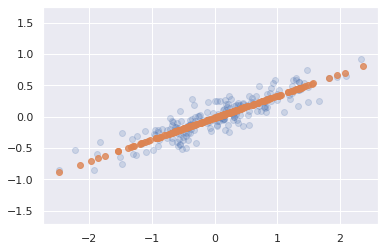

In [10]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

Los puntos mas claros representan los datos originales y los puntos mas oscuros representan los puntos proyectados con menos dimesiones.

La información sobre los componentes principales menos importantes es removida 
y se preserva las componetes con mas alta varianza.

Estas componentes principales preservan la relaciones mas importantes entre los datos.


### PCA Visualización: Digitos escritos a mano

La verdadera fortaleza en la redución de dimensionalidad la podemos apreciar cuando tenesmo problemas con alta dimensionalidad. El siguente ejemplo tiene 64 dimensiones.


In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

los datos consisten en 1797 imagenes de 8x8 pixeles lo que significa 4 dimensiones, si tomamos como carcaterisitcas cada uno de los pixeles.



In [12]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


El siguente grafico muestra los 2 principales componentes de la 1767 images. Lo cual permite pasar de 64 dimensiones a 2 dimensiones

(1797,)


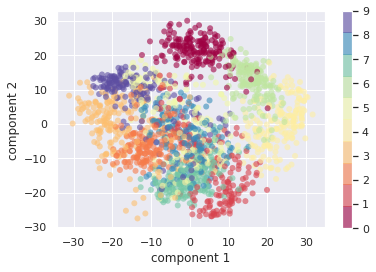

In [13]:
print(digits.target.shape)
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.6,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Que significado tiene esto: los datos completos que estaban tenian una dimensionalidad de 64 osea una nube de puntos con 64 autovalores y autovectores, los cuales se han proyectado a lo largo de las 2 direcciones con las mas alta varinza. 

Lo que sea encontrado es la transformacion (translación, rotación escalado) adecuada que permite llevar los datos de un espacio de 64 dimensiones a un espacion en 2 dimensiones. Lo cual se ha podido hacer de forma no supervisionada sin la necesidad de referenciar etiquetas.


### Que significan los componentes?

o nos podemos preguntar que significa reducir la dimensionalidad.

Esto puede ser entendido en terminos de combincación de vetores base. 

Por ejemplo, cada imagen para un conjunto de datos de entrenamiento puede ser definida como la colección de sus pixels que para nuetro ejemplo anterior es 64, lo cual podemos llamar el vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

Una forma en la que podemos pensar en esto es terminos de una base de pixeles 

Es decir, para construir la imagen, multiplicamos cada elemento del vector por el píxel que describe, y luego sumamos los resultados para construir la imagen:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

Una forma en que podríamos imaginar reducir la dimensión de estos datos es poner a cero todos menos algunos de estos vectores básicos.

Por ejemplo, si usamos solo los primeros ocho píxeles, obtenemos una proyección de ocho dimensiones de los datos, pero no refleja muy bien toda la imagen: ¡hemos eliminado casi el 90% de los píxeles!


![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.09-digits-pixel-components.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Digits-Pixel-Components)

La fila superior de imagenes muestra los píxeles individuales, y la fila inferior muestra la contribución acumulativa de estos píxeles a la construcción de la imagen.
Usando solo ocho de los componentes basados ​​en píxeles, solo podemos construir una pequeña porción de la imagen de 64 píxeles.
Si continuáramos esta secuencia y utilizáramos los 64 píxeles, recuperaríamos la imagen original.

Pero la representación en píxeles no es la única opción de base. También podemos usar otras funciones básicas, cada una de las cuales contiene alguna contribución predefinida de cada píxel, y escribir algo como


$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

La PCA puede considerarse como un proceso de elección de funciones básicas óptimas, de modo que sumar solo las primeras es suficiente para reconstruir adecuadamente la mayor parte de los elementos en el conjunto de datos.
Los componentes principales, que actúan como la representación de baja dimensión de nuestros datos, son simplemente los coeficientes que multiplican cada uno de los elementos de esta serie.
Esta figura muestra una descripción similar de la reconstrucción de este dígito utilizando la media más las primeras ocho funciones básicas de PCA:



![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.09-digits-pca-components.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Digits-PCA-Components)

A diferencia de la base de píxeles, la base de PCA nos permite recuperar las características más destacadas de la imagen de entrada con solo una media más ocho componentes.

En este sentido, PCA proporciona una representación de baja dimensión de los datos: descubre un conjunto de funciones básicas que son más eficientes que la base de píxeles nativa de los datos de entrada.

### Elegir el número de componentes

Una parte vital del uso de PCA en la práctica es la capacidad de estimar cuántos componentes se necesitan para describir los datos.
Esto se puede determinar observando la relación de varianza explicada * acumulativa * en función del número de componentes:

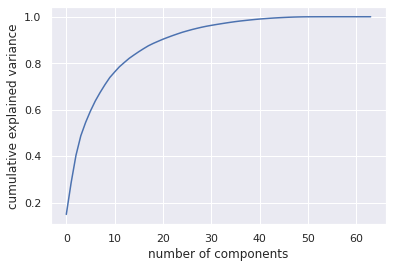

In [15]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Esta curva cuantifica cuánto de la varianza total de 64 dimensiones está contenida dentro de los primeros componentes $N$. Por ejemplo, vemos que con los dígitos los primeros 10 componentes contienen aproximadamente el 75% de la varianza, mientras que usted necesita alrededor de 50 componentes para describir cerca del 100% de la varianza.

Aquí vemos que nuestra proyección bidimensional pierde mucha información (medida por la varianza explicada) y que necesitaríamos alrededor de 20 componentes para retener el 90% de la varianza. Mirar este gráfico para un conjunto de datos de alta dimensión puede ayudarlo a comprender el nivel de redundancia presente en múltiples observaciones.



## PCA como filtro de ruido

PCA también se puede utilizar como un enfoque de filtrado para datos ruidosos.
La idea es esta: cualquier componente con una varianza mucho mayor que el efecto del ruido no debería verse afectado por el ruido.
Por lo tanto, si reconstruye los datos utilizando solo el subconjunto más grande de componentes principales, debe mantener preferentemente la señal y eliminar el ruido.

Veamos cómo se ve esto con los datos de dígitos.
Primero trazaremos varios de los datos de entrada sin ruido:

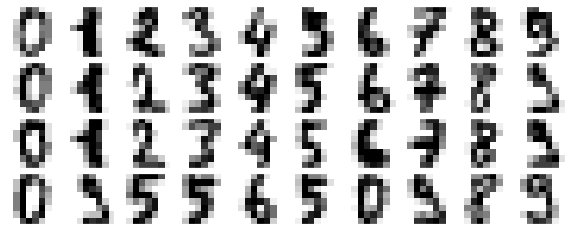

In [16]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Ahora agreguemos un poco de ruido aleatorio para crear un conjunto de datos ruidoso y vuelva a trazarlo:

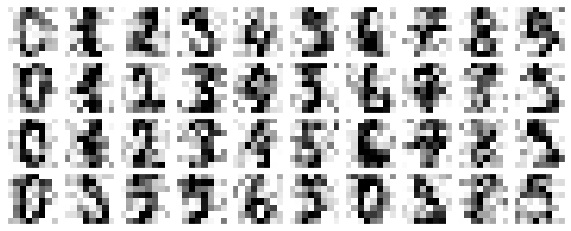

In [17]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

A simple vista, está claro que las imágenes son ruidosas y contienen píxeles espurios. Entrenemos a un PCA sobre los datos ruidosos, solicitando que la proyección conserve el 50% de la varianza:

In [18]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

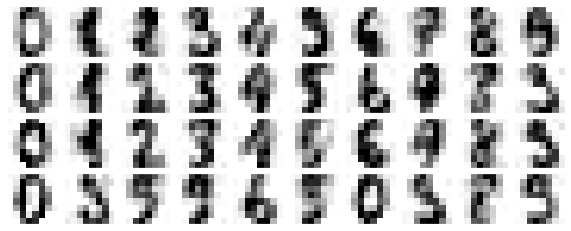

In [19]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

Esta propiedad de preservación de señal / filtro de ruido hace que PCA sea una rutina de selección de características muy útil; por ejemplo, en lugar de entrenar a un clasificador con datos de muy alta dimensión, puede entrenar al clasificador con la representación de menor dimensión, que servirá automáticamente para filtrar  ruido aleatorio en las entradas.

## Ejemplo: selector de caracteristicas

PCA como selector de features para reconocimiento facial


In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Observemos los ejes principales que representan este conjunto de datos.

Debido a que este es un gran conjunto de datos, usaremos `` RandomizedPCA `` este contiene un método aleatorio para aproximar los primeros $ N $ componentes principales  mucho más rápido que el estimador estándar de `` PCA `` y por lo tanto, es muy útil para datos con altas dimensiones (este ejemplo tiene una dimensionalidad de casi 3.000).
nosotros usaremos los primeros 150 componentes:



In [21]:
from sklearn.decomposition import PCA as RandomizedPCA
#from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

En este caso, puede ser interesante visualizar las imágenes asociadas con los primeros componentes principales (estos componentes se conocen técnicamente como "vectores propios", por lo que este tipo de imágenes a menudo se llaman "caras propias").

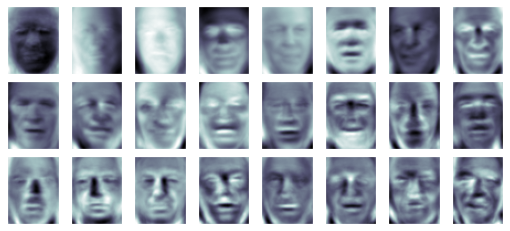

In [0]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Los resultados son muy interesantes, y nos dan una idea de cómo varían las imágenes: por ejemplo, las primeras caras propias (desde la parte superior izquierda) parecen estar asociadas con el ángulo de iluminación en la cara, y luego los vectores principales parecen estar destacando ciertas características, como ojos, narices y labios. Miremos ahora la varianza acumulativa de estos componentes para ver cuánta información de datos conserva la proyección:



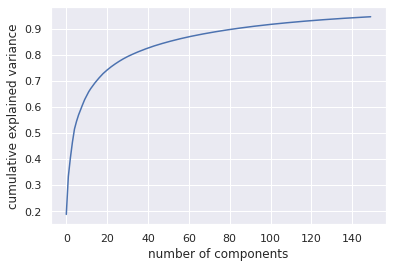

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Vemos que estos 150 componentes representan poco más del 90% de la variación. Eso nos llevaría a creer que con estos 150 componentes, recuperaríamos la mayoría de las características esenciales de los datos. Para hacer esto más concreto, podemos comparar las imágenes de entrada con las imágenes reconstruidas a partir de estos 150 componentes:


In [0]:
# Compute the components and projected faces
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

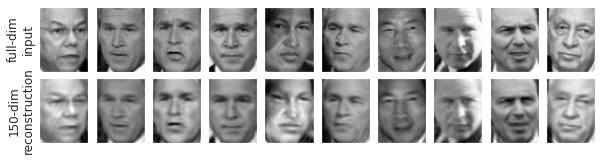

In [24]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

La fila superior aquí muestra las imágenes de entrada, mientras que la fila inferior muestra la reconstrucción de las imágenes con solo 150 de las ~ 3.000 características iniciales.

Aunque reduce la dimensionalidad de los datos en casi un factor de 20, Las imágenes proyectadas contienen suficiente información que podríamos, a simple vista, reconocer a los individuos en la imagen.
Lo que esto significa es que nuestro algoritmo de clasificación necesita ser entrenado en datos de 150 dimensiones en lugar de datos de 3,000 dimensiones, que dependiendo del algoritmo particular que elijamos, puede conducir a una clasificación mucho más eficiente.


## Resumen del análisis de componentes principales

Hemos discutido el uso del análisis de componentes principales para la reducción de la dimensionalidad, para la visualización de datos de alta dimensión, para el filtrado de ruido y para la selección de características dentro de los datos de alta dimensión.

Debido a la versatilidad e interpretabilidad de PCA, se ha demostrado que es eficaz en una amplia variedad de contextos y disciplinas.para comprender la varianza principal en los datos y entender La dimensionalidad intrínseca (trazando la relación de varianza explicada)

Ciertamente, PCA no es útil para todos los conjuntos de datos de alta dimensión, pero ofrece una ruta directa y eficiente para obtener información sobre datos de alta dimensión.

La principal debilidad de PCA es que tiende a verse muy afectada por los valores atípicos en los datos.
Por esta razón, se han desarrollado muchas variantes robustas de PCA, muchas de las cuales actúan para descartar iterativamente los puntos de datos que están mal descritos por los componentes iniciales.
Scikit-Learn contiene un par de variantes interesantes en PCA, incluyendo `` RandomizedPCA`` y `` SparsePCA``, ambas también en el submódulo `` sklearn.decomposition``.
`` RandomizedPCA``, que vimos anteriormente, utiliza un método no determinista para aproximar rápidamente los primeros componentes principales en datos de muy alta dimensión, mientras que `` SparsePCA`` introduce un término de regularización.
